# Solution: Amoeba Classification

This is the solution for amoeba classification assignment.

Here, we use the images that are collected from our lab to train our own custom model to classify the images if they contain amoeba or not. The dataset is not large enough, we use two techniques to make our experiment reproducible: **data augmentation** and **repeat the experiment multiple times**.


## Table of content

* Load images dataset
* Data preparation
* Build and train the model
* Evaluate the model
* Inference

# Load images dataset

The images dataset is loaded and we will use them to train our custom model. All of the images are collected in our lab.  

In [ ]:
# import packages
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from tensorflow import keras


In [23]:
print(tf.__version__)
print(keras.__version__)

2.12.0
2.12.0


In [1]:
# download dataset from github

%%shell
git clone https://github.com/BaosenZ/amoeba-detection.git


Cloning into 'amoeba-detection'...
remote: Enumerating objects: 2604, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 2604 (delta 2), reused 1 (delta 1), pack-reused 2601
Receiving objects: 100% (2604/2604), 358.07 MiB | 14.01 MiB/s, done.
Resolving deltas: 100% (607/607), done.
Updating files: 100% (3546/3546), done.


In [2]:
# copy the dataset from github folder to 'content'
!cp -r '/content/amoeba-detection/dataset-section1/dataset-amoebaClassification' '/content'

In [3]:
# upload zip file of the dataset from local

# from google.colab import files
# uploaded = files.upload()
# for fn in uploaded.keys():
#     print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

# !unzip dataset-amoebaClassification.zip

# Data preparation

In this step, we will prepare dataset, including data augmentation, spliting training, validation and test dataset, and normalize dataset. More way to prepare the dataset can be found here: https://keras.io/api/data_loading/image/.

## Data augmentation

Data augmentation can obtain more data for training and validation. When the training dataset is small, we can do data augmentation to existing data and add those data to the training dataset. For image data specifically, data augmentation could consist of things like flipping the image horizontally or vertically, rotating the image, zooming in or out, cropping, or varying the color and so on.

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15, zoom_range=0.1,
    channel_shift_range=10., horizontal_flip=True)

# Data augmentation for train amoeba dataset
fileList=os.listdir("./dataset-amoebaClassification/train/amoeba/")

for i in fileList:
    image_path = 'dataset-amoebaClassification/train/amoeba/' + i
    image = np.expand_dims(plt.imread(image_path),0)
    aug_iter = gen.flow(image)
    aug_images = [next(aug_iter)[0].astype(np.uint8) for m in range(2)]

    for j in range(0,2):
        img = Image.fromarray(aug_images[j])
        save_path = './dataset-amoebaClassification/train/amoeba' + "/" + "aug-" + str(j) + str(i)
        img.save(save_path)

# The augmentation image will save into ./dataset-amoebaClassification/train/amoeba folder. Check this folder and find out\
# augmentation image with prefix 'aug-'.

In [5]:
# Data augmentation for train noAmoeba dataset
fileList2=os.listdir("./dataset-amoebaClassification/train/noAmoeba/")

for i2 in fileList2:
    image_path = 'dataset-amoebaClassification/train/noAmoeba/' + i2
    image = np.expand_dims(plt.imread(image_path),0)
    aug_iter = gen.flow(image)
    aug_images = [next(aug_iter)[0].astype(np.uint8) for m2 in range(2)]

    for j2 in range(0,2):
        img = Image.fromarray(aug_images[j2])
        save_path = './dataset-amoebaClassification/train/noAmoeba' + "/" + "aug-" + str(j2) + str(i2)
        img.save(save_path)

# The augmentation image will save into ./dataset-amoebaClassification/train/noAmoeba folder. Check this folder and find out\
# augmentation image with prefix 'aug-'.

In [6]:
# Data augmentation for test Amoeba dataset
fileList3=os.listdir("./dataset-amoebaClassification/test/amoeba/")

for i3 in fileList3:
    image_path = 'dataset-amoebaClassification/test/amoeba/' + i3
    image = np.expand_dims(plt.imread(image_path),0)
    aug_iter = gen.flow(image)
    aug_images = [next(aug_iter)[0].astype(np.uint8) for m3 in range(2)]

    for j3 in range(0,2):
        img = Image.fromarray(aug_images[j3])
        save_path = './dataset-amoebaClassification/test/amoeba' + "/" + "aug-" + str(j3) + str(i3)
        img.save(save_path)

# The augmentation image will save into ./dataset-amoebaClassification/test/amoeba folder. Check this folder and find out\
# augmentation image with prefix 'aug-'.

In [7]:
# Data augmentation for test noAmoeba dataset
fileList4=os.listdir("./dataset-amoebaClassification/test/noAmoeba/")

for i4 in fileList4:
    image_path = 'dataset-amoebaClassification/test/noAmoeba/' + i4
    image = np.expand_dims(plt.imread(image_path),0)
    aug_iter = gen.flow(image)
    aug_images = [next(aug_iter)[0].astype(np.uint8) for m4 in range(2)]

    for j4 in range(0,2):
        img = Image.fromarray(aug_images[j4])
        save_path = './dataset-amoebaClassification/test/noAmoeba' + "/" + "aug-" + str(j4) + str(i4)
        img.save(save_path)

# The augmentation image will save into ./dataset-amoebaClassification/test/noAmoeba folder. Check this folder and find out\
# augmentation image with prefix 'aug-'.

## Split and normalize the dataset

In [8]:
import os
import numpy as np
from tqdm import tqdm
from glob import glob
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

# training data preparation

# define image size, it can be modified
img_size = 150
# training images dataset path
train_path = 'dataset-amoebaClassification/train'
nub_train = len(glob(train_path + '/*/*.jpg'))
# Create empty array, fill out the image array to newly-created array.
X_train_full = np.zeros((nub_train,img_size,img_size,3),dtype=np.uint8)
y_train_full = np.zeros((nub_train,),dtype=np.uint8)

i = 0
for img_path in tqdm(glob(train_path + '/*/*.jpg')):
    img = Image.open(img_path)
    # image resize
    img = img.resize((img_size,img_size))
    # images are converted to array
    arr = np.asarray(img)
    # assign array
    X_train_full[i, :, :, :] = arr

    if img_path.split('/')[-2] == 'amoeba':
        # Set amoeba class as 1
        y_train_full[i] = 1
    else:
        # Set no amoeba class as 0
        y_train_full[i] = 0

    i += 1

100%|██████████| 1077/1077 [00:27<00:00, 39.50it/s]


In [9]:
# # test data preparation

img_size = 150
test_path = 'dataset-amoebaClassification/test'
nub_test = len(glob(test_path + '/*/*.jpg'))

X_test = np.zeros((nub_test,img_size,img_size,3),dtype=np.uint8)
y_test = np.zeros((nub_test,),dtype=np.uint8)

i = 0
for img_path in tqdm(glob(test_path + '/*/*.jpg')):
    img = Image.open(img_path)
    img = img.resize((img_size,img_size))
    arr = np.asarray(img)
    X_test[i, :, :, :] = arr

    if img_path.split('/')[-2] == 'amoeba':
        # Set amoeba class as 1
        y_test[i] = 1
    else:
        # Set no amoeba class as 0
        y_test[i] = 0

    i += 1

100%|██████████| 198/198 [00:06<00:00, 32.13it/s]


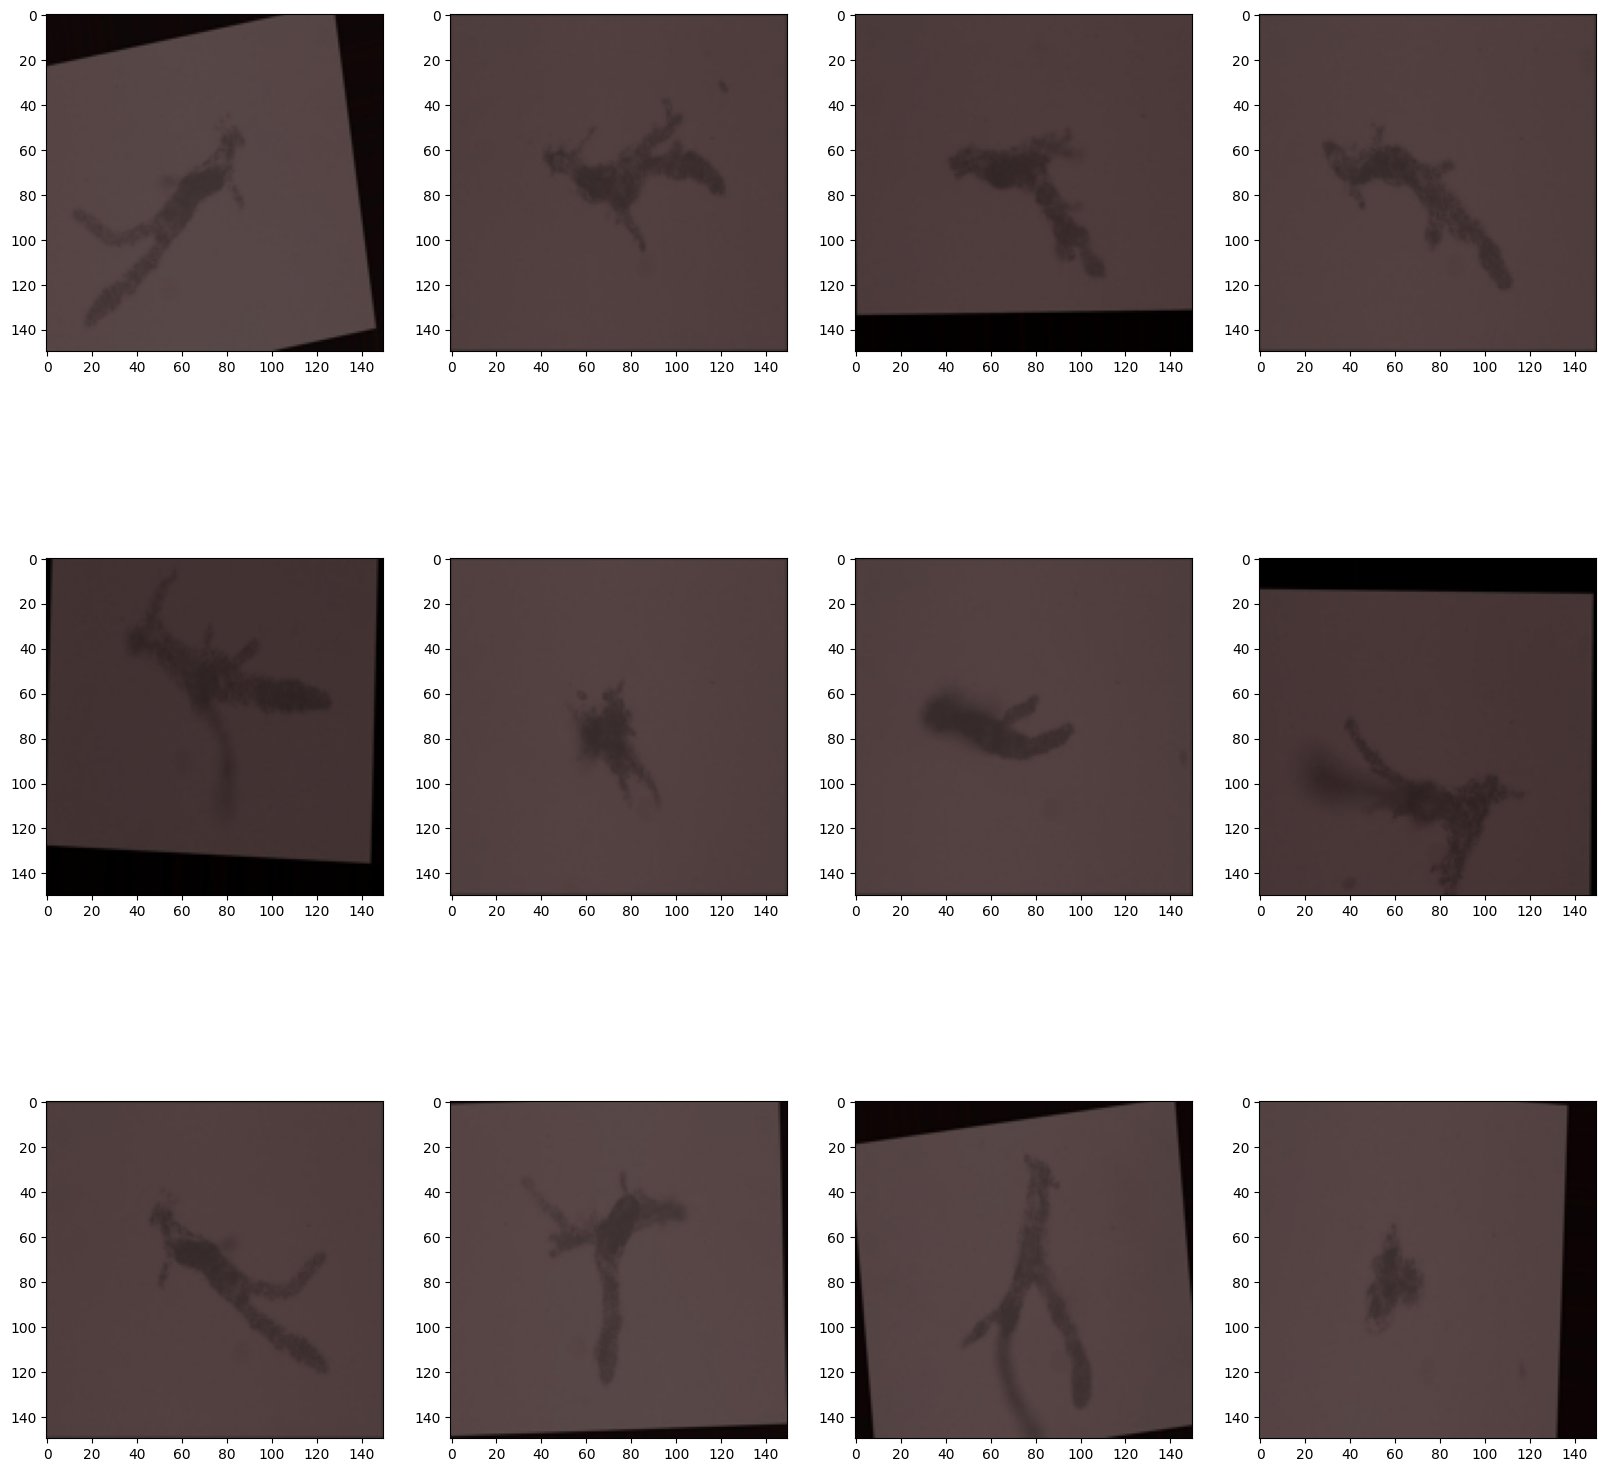

In [10]:
# # Visualize the training dataset
fig,axes = plt.subplots(3,4,figsize=(20, 20))

j = 0
for i,img in enumerate(X_train_full[:12]):
    axes[i//4,j%4].imshow(img)
    j+=1

In [11]:
# normalize the dataset
X_mean = X_train_full.mean(axis=0, keepdims=True)
X_std = X_train_full.std(axis=0, keepdims=True) + 1e-7
X_train_full_norm = (X_train_full - X_mean) / X_std
X_test_norm = (X_test - X_mean) / X_std

X_train_full_norm = X_train_full_norm[..., np.newaxis]
X_test_norm = X_test_norm[..., np.newaxis]

In [12]:
# Split the X_train_full_norm and y_train_full dataset randomly
def split_dataset(X_train_full_norm, y_train_full):
    # randomize X_train_full_norm and y_train_full array at the same order
    total_images = len(X_train_full_norm)
    idx = np.random.choice(np.arange(total_images), total_images, replace=False)
    X_train_full_norm = X_train_full_norm[idx]
    y_train_full = y_train_full[idx]

    # split the X_train_full into X_train(3/4) and X_valid(1/4)
    X_train_norm, X_validation_norm = X_train_full_norm[0 : int(total_images*3/4)], X_train_full_norm[int(total_images*3/4):total_images]
    y_train, y_validation = y_train_full[0 : int(total_images*3/4)], y_train_full[int(total_images*3/4):total_images]
    return X_train_norm, X_validation_norm, y_train, y_validation

X_train_norm, X_validation_norm, y_train, y_validation = split_dataset(X_train_full_norm, y_train_full)
print("length of X_train_norm: ", len(X_train_norm))
print("length of X_validation_norm: ", len(X_validation_norm))

length of X_train_norm:  807
length of X_validation_norm:  270


# Build and train the model

## one experiment training code (hidden)
This is the same with Section 1.

Simple convolustional neural network (CNN) is used to train the model. It is usually composed of different layers in keras. The Layers are the basic building blocks of neural networks in Keras. Those layers are composed of and can be referred in Keras doc: convolutional layers (https://keras.io/api/layers/convolution_layers/convolution2d/), pooling layer (https://keras.io/api/layers/pooling_layers/), input and dense layer (https://keras.io/api/layers/core_layers/), flatten layer (https://keras.io/api/layers/reshaping_layers/flatten/). The layer or CNN structure can refer to example in keras doc ( https://keras.io/examples/vision/mnist_convnet/) or related books (such as •	Géron, A., 2019. Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow: Concepts, tools, and techniques to build intelligent systems. " O'Reilly Media, Inc.".).

In [13]:
# Build the model (sequential CNN model)
# from functools import partial

# DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, activation='relu', padding="SAME")

# model = keras.models.Sequential([
#     DefaultConv2D(filters=64, kernel_size=7, input_shape=[150, 150, 3]),  # input shape should match the input image size
#     keras.layers.MaxPooling2D(pool_size=2),
#     DefaultConv2D(filters=128),
#     DefaultConv2D(filters=128),
#     keras.layers.MaxPooling2D(pool_size=2),
#     DefaultConv2D(filters=256),
#     DefaultConv2D(filters=256),
#     keras.layers.MaxPooling2D(pool_size=2),
#     keras.layers.Flatten(),
#     keras.layers.Dense(units=128, activation='relu'),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(units=64, activation='relu'),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(units=32, activation='relu'),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(units=16, activation='relu'),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(units=2, activation='softmax'),
# ])

The purpose of loss functions is to compute the quantity that a model should seek to minimize during training. For more available loss function, refer keras doc: https://keras.io/api/losses/

An optimizer is a function that modifies the attributes of the neural network, such as weights and learning rate. Thus, it helps in reducing the overall loss and improve the accuracy. For more available optimizer, refer keras doc: https://keras.io/api/optimizers/

A metric is a function that is used to judge the performance of your model. For more available metrics, refer keras doc: https://keras.io/api/metrics/

In [14]:
# Compile the model
# opt = keras.optimizers.Nadam(learning_rate=0.00001)  # learning rate can be changed to increase the performance of the model
# model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

Then we will start to train the model by calling `model.fit()` and save the model by calling `model.save()`. More information about these two functions are in the Keras doc: https://keras.io/api/models/.

In [15]:
# Train the model
# history = model.fit(X_train_norm, y_train, epochs=20, validation_data=[X_valid_norm, y_valid])

## Multiple experiments training code

In this example, we repeat experiment for 5 times and collect 5 different trained model.

In [16]:
# Train the model
from functools import partial
# Create a dir to save our model
if not os.path.exists("model_dir"):
  os.mkdir("model_dir")

repeat_exp = 6  # Set how many times (repeat_exp - 1) you want to repeat the experiment
for i in range(1, repeat_exp):
    # Split the dataset randomly
    X_train_norm, X_validation_norm, y_train, y_validation = split_dataset(X_train_full_norm, y_train_full)

    # rebuild the model
    DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, activation='relu', padding="SAME")
    model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[150, 150, 3]),  # input shape should match the input image size
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=16, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=2, activation='softmax'),
    ])

    # Compile the model
    opt = keras.optimizers.Nadam(learning_rate=0.00001)  # learning rate can be changed to increase the performance of the model
    model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

    # Start to train the model
    print("start repetition ", i)
    history = model.fit(X_train_norm, y_train, epochs=15, validation_data=(X_validation_norm, y_validation))
    # Save the trained model in model_dir dir
    saved_model = "model_dir/" + "model" + str(i)
    model.save(saved_model)

start repetition  1
Epoch 1/15
26/26 [==============================] - 25s 210ms/step - loss: 0.6837 - accuracy: 0.4783 - val_loss: 0.6550 - val_accuracy: 0.7148
Epoch 2/15
26/26 [==============================] - 3s 106ms/step - loss: 0.6534 - accuracy: 0.5006 - val_loss: 0.5952 - val_accuracy: 0.8000
Epoch 3/15
26/26 [==============================] - 3s 104ms/step - loss: 0.6297 - accuracy: 0.5167 - val_loss: 0.5690 - val_accuracy: 0.8333
Epoch 4/15
26/26 [==============================] - 3s 104ms/step - loss: 0.5918 - accuracy: 0.5898 - val_loss: 0.5351 - val_accuracy: 0.8963
Epoch 5/15
26/26 [==============================] - 3s 106ms/step - loss: 0.5950 - accuracy: 0.5911 - val_loss: 0.5139 - val_accuracy: 0.9333
Epoch 6/15
26/26 [==============================] - 3s 109ms/step - loss: 0.5640 - accuracy: 0.6295 - val_loss: 0.4710 - val_accuracy: 0.9704
Epoch 7/15
26/26 [==============================] - 3s 108ms/step - loss: 0.5440 - accuracy: 0.6146 - val_loss: 0.4292 - val_ac

start repetition  2
Epoch 1/15
26/26 [==============================] - 8s 121ms/step - loss: 0.6645 - accuracy: 0.5564 - val_loss: 0.6160 - val_accuracy: 0.5296
Epoch 2/15
26/26 [==============================] - 3s 110ms/step - loss: 0.5980 - accuracy: 0.6084 - val_loss: 0.5081 - val_accuracy: 0.8037
Epoch 3/15
26/26 [==============================] - 3s 108ms/step - loss: 0.5395 - accuracy: 0.6369 - val_loss: 0.4411 - val_accuracy: 0.8630
Epoch 4/15
26/26 [==============================] - 3s 106ms/step - loss: 0.5243 - accuracy: 0.6555 - val_loss: 0.4261 - val_accuracy: 0.8778
Epoch 5/15
26/26 [==============================] - 3s 106ms/step - loss: 0.4951 - accuracy: 0.6741 - val_loss: 0.3753 - val_accuracy: 0.9370
Epoch 6/15
26/26 [==============================] - 3s 109ms/step - loss: 0.4886 - accuracy: 0.6617 - val_loss: 0.3671 - val_accuracy: 0.9444
Epoch 7/15
26/26 [==============================] - 3s 110ms/step - loss: 0.4627 - accuracy: 0.6964 - val_loss: 0.3525 - val_acc

start repetition  3
Epoch 1/15
26/26 [==============================] - 8s 131ms/step - loss: 0.6781 - accuracy: 0.5403 - val_loss: 0.6445 - val_accuracy: 0.5741
Epoch 2/15
26/26 [==============================] - 3s 106ms/step - loss: 0.6458 - accuracy: 0.5787 - val_loss: 0.5775 - val_accuracy: 0.7407
Epoch 3/15
26/26 [==============================] - 3s 108ms/step - loss: 0.5963 - accuracy: 0.6283 - val_loss: 0.5060 - val_accuracy: 0.8296
Epoch 4/15
26/26 [==============================] - 3s 107ms/step - loss: 0.5699 - accuracy: 0.6258 - val_loss: 0.4618 - val_accuracy: 0.8852
Epoch 5/15
26/26 [==============================] - 3s 109ms/step - loss: 0.5774 - accuracy: 0.6171 - val_loss: 0.4518 - val_accuracy: 0.9259
Epoch 6/15
26/26 [==============================] - 3s 109ms/step - loss: 0.5486 - accuracy: 0.6778 - val_loss: 0.4142 - val_accuracy: 0.9333
Epoch 7/15
26/26 [==============================] - 3s 107ms/step - loss: 0.5270 - accuracy: 0.6815 - val_loss: 0.3925 - val_acc

start repetition  4
Epoch 1/15
26/26 [==============================] - 9s 127ms/step - loss: 0.6615 - accuracy: 0.5527 - val_loss: 0.5910 - val_accuracy: 0.7815
Epoch 2/15
26/26 [==============================] - 3s 107ms/step - loss: 0.5883 - accuracy: 0.6307 - val_loss: 0.4965 - val_accuracy: 0.8037
Epoch 3/15
26/26 [==============================] - 3s 108ms/step - loss: 0.5429 - accuracy: 0.6221 - val_loss: 0.4439 - val_accuracy: 0.8741
Epoch 4/15
26/26 [==============================] - 3s 108ms/step - loss: 0.5010 - accuracy: 0.6406 - val_loss: 0.4083 - val_accuracy: 0.8741
Epoch 5/15
26/26 [==============================] - 3s 112ms/step - loss: 0.4693 - accuracy: 0.6766 - val_loss: 0.3845 - val_accuracy: 0.9111
Epoch 6/15
26/26 [==============================] - 3s 109ms/step - loss: 0.4491 - accuracy: 0.6530 - val_loss: 0.3661 - val_accuracy: 0.9222
Epoch 7/15
26/26 [==============================] - 3s 111ms/step - loss: 0.4433 - accuracy: 0.6828 - val_loss: 0.3521 - val_acc

start repetition  5
Epoch 1/15
26/26 [==============================] - 9s 127ms/step - loss: 0.6715 - accuracy: 0.4746 - val_loss: 0.6111 - val_accuracy: 0.6630
Epoch 2/15
26/26 [==============================] - 3s 107ms/step - loss: 0.6075 - accuracy: 0.4957 - val_loss: 0.5453 - val_accuracy: 0.8778
Epoch 3/15
26/26 [==============================] - 3s 109ms/step - loss: 0.5745 - accuracy: 0.5799 - val_loss: 0.5005 - val_accuracy: 0.8667
Epoch 4/15
26/26 [==============================] - 3s 111ms/step - loss: 0.5422 - accuracy: 0.5713 - val_loss: 0.4540 - val_accuracy: 0.8852
Epoch 5/15
26/26 [==============================] - 3s 110ms/step - loss: 0.5203 - accuracy: 0.5527 - val_loss: 0.4341 - val_accuracy: 0.9741
Epoch 6/15
26/26 [==============================] - 3s 108ms/step - loss: 0.5004 - accuracy: 0.6072 - val_loss: 0.4096 - val_accuracy: 0.9889
Epoch 7/15
26/26 [==============================] - 3s 111ms/step - loss: 0.4784 - accuracy: 0.6382 - val_loss: 0.3984 - val_acc

# Evaluate the model

In [17]:
# visualize the model structure with model.summary(). Feel free to comment out the code below to visualize the model structure

# model.summary()

The test dataset is not used for training and validation, which means they are new to the trained model. And we will use it to get the performance of the model. The performance is acceptable because the accuracy for test dataset is nearly the same with accuracy for train and validation dataset.

Another way to evaluate the small dataset is to repeat the experiment of evaluating the model multiple times. And we can calculate mean test accuracy.

In [18]:
import os
fileList = os.listdir("./model_dir/")

test_accuracy_list = list()
loss_list = list()
for m in fileList:
    model = keras.models.load_model("./model_dir/"+m) # m='model.h5'
    results = model.evaluate(X_test_norm, y_test, batch_size=128)
    test_accuracy_list.append(results[1])
    loss_list.append(results[0])

mean_test_accuracy = np.mean(test_accuracy_list)
print("mean test accuracy: ", mean_test_accuracy)

2/2 [==============================] - 0s 82ms/step - loss: 0.3749 - accuracy: 1.0000


2/2 [==============================] - 0s 82ms/step - loss: 0.3712 - accuracy: 0.9848


2/2 [==============================] - 1s 98ms/step - loss: 0.3151 - accuracy: 1.0000
mean test accuracy:  0.9909090995788574


Find out the best model among all trained models.

In [19]:
# find the best model
for a,b,c in zip(fileList, test_accuracy_list, loss_list):
    maxb = max(test_accuracy_list)
    minc = min(loss_list)
    if b == maxb and c==minc:
        model = keras.models.load_model("./model_dir/"+a)

At the end of epoch, the accuary for training and validation dataset should be close. This is an easy way to determine if there is overfitting or not.

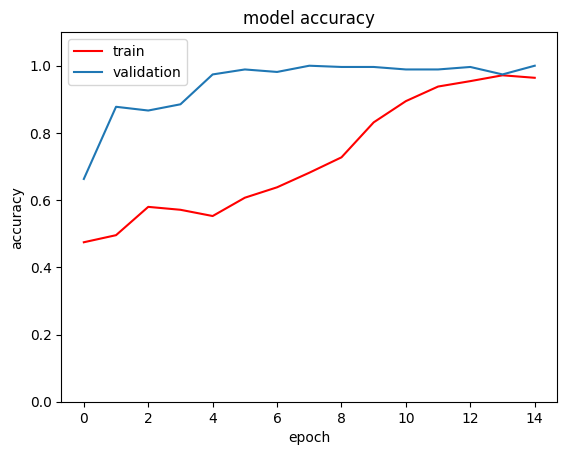

In [20]:
# plot accuracy vs epoch
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.ylim([0, 1.1])
plt.show()

# Inference

We will run inference using the best model we find.

We visualize the image and use your judgement to see if there is amoeba exist in the image and then compare it with the model prediction.

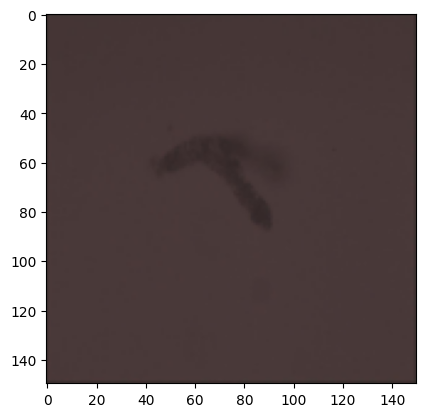

In [24]:
import keras.utils as image

# Visualize one image, X_test[x]. Here we choose X_test[1]. You can choose any of the images among all test dataset
inference_image_number = 1  # Choose the number from 0-197 (amount of test dataset)!
img1 = X_test[inference_image_number]
plt.imshow(img1)

We will predict the image above with `model.predict()` function to see if it matches with your judgement. Check the `model.predict()` reference: https://keras.io/api/models/model_training_apis/#predict-method

In [22]:
# class label
class_label = ['no amoeba exists', 'amoeba exists']

# image process
x = np.squeeze(X_test_norm[inference_image_number])
x = image.img_to_array(x)
x = np.expand_dims(x, axis=0)

# predict the image with model.predict()
y_prob = model.predict(x)
print("probability for each of the catogaries: ", y_prob)
y_class = y_prob.argmax(axis=-1)
print("model predict: ", class_label[y_class[0]])

1/1 [==============================] - 1s 702ms/step
probability for each of the catogaries:  [[0.4960647  0.50393534]]
model predict:  amoeba exists
